In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, MultiTaskElasticNet, LassoLars, SGDRegressor
from sklearn.svm import LinearSVR, SVR, NuSVR
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, RobustScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import make_scorer
from sklearn.pipeline import make_pipeline

In [2]:
from catboost import CatBoostRegressor
import xgboost as xgb
import lightgbm as lgb

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
customers = pd.read_csv("customers.tsv", sep='\t')
sales = pd.read_csv("sales.tsv", sep='\t')

In [5]:
sales.head()

,year,month,location,ira,product_category,brand,sku_id,item_per_bundle,shape,with_alcohol,filling,volume,price
0,2017,1,Alpha City,AC,Chocolates,Cadbury,sku #79,1,Standart,No,Nothing,4572.0,NaN
1,2017,1,Alpha City,AC,Chocolates,Ferrero Rocher,sku #15,1,Standart,No,Nothing,8028.0,1.221336
2,2017,1,Alpha City,AC,Chocolates,Ferrero Rocher,sku #16,3,Standart,No,Nothing,6606.0,2.866401
3,2017,1,Alpha City,AC,Chocolates,Ferrero Rocher,sku #22,2,Standart,No,Nothing,11688.0,2.093719
4,2017,1,Alpha City,AC,Chocolates,Ferrero Rocher,sku #28,3,Standart,No,Nothing,3582.0,2.866401


In [6]:
sales.shape

(1729, 13)

In [7]:
customers.head()

,year,month,ira,customers_type,amount_of_customers
0,2017,1,AC,Archer,679.0
1,2017,1,AC,Monk,1070.0
2,2017,1,AC,Dwarf,610.0
3,2017,1,AC,Centaur,1315.0
4,2017,1,AC,Gremlin,1554.0


In [8]:
customers.shape

(1980, 5)

## Let's look for possible values of our parameters and check how appropriate they are

In [9]:
for col in sales.columns[:-2]:
    print(sales[col].unique())

[2017 2018 2019]
[ 1  2  3  4  5  6  7  8  9 10 11 12]
['Alpha City' 'Moon' 'Pirate Bay' 'Village']
['AC' 'MN' 'PB' 'VL']
['Chocolates' 'Lollipops']
['Cadbury' 'Ferrero Rocher' 'Milka' 'Toblerone' 'Twix' 'Snickers'
 'Chupa Chups']
['sku #79' 'sku #15' 'sku #16' 'sku #22' 'sku #28' 'sku #30' 'sku #31'
 'sku #33' 'sku #38' 'sku #41' 'sku #46' 'sku #48' 'sku #49' 'sku #42'
 'sku #67' 'sku #25' 'sku #73' 'sku #78' 'sku #34' 'sku #37' 'sku #27'
 'sku #43' 'sku #44' 'sku #72' 'sku #81' 'sku #82' 'sku #83' 'sku #84'
 'sku #7' 'sku #11' 'sku #17' 'sku #3' 'sku #5' 'sku #94' 'sku #106'
 'sku #76' 'sku #77' 'sku #97' 'sku #100' 'sku #55' 'sku #98' 'sku #60'
 'sku #105']
[1 3 2]
['Standart' 'Square' 'Round']
['No' 'Yes']
['Nothing' 'Nuts' 'Berries']


In [10]:
sales.tail()

,year,month,location,ira,product_category,brand,sku_id,item_per_bundle,shape,with_alcohol,filling,volume,price
1724,2019,6,Pirate Bay,PB,Lollipops,Chupa Chups,sku #97,1,Round,No,Nuts,5790.0,1.316449
1725,2019,6,Village,VL,Chocolates,Ferrero Rocher,sku #30,1,Standart,No,Nothing,394.0,1.251254
1726,2019,6,Village,VL,Chocolates,Ferrero Rocher,sku #46,1,Standart,No,Nothing,197.0,1.251254
1727,2019,6,Village,VL,Chocolates,Toblerone,sku #25,1,Standart,No,Nothing,49.0,1.251254
1728,2019,6,Village,VL,Chocolates,Toblerone,sku #73,1,Standart,No,Nothing,49.0,1.251254


## While I was trying to find what the International Retail Association (IRA) locations classification is, I noticed that in our case it’s just a short form of the “location” column

In [11]:
sales[['location', 'ira']].drop_duplicates()

,location,ira
0,Alpha City,AC
18,Moon,MN
33,Pirate Bay,PB
204,Village,VL


In [12]:
for col in customers.columns:
    print(customers[col].unique())

[2017 2018 2019]
[ 1  2  3  4  5  6  7  8  9 10 11 12]
['AC' 'MN' 'PB']
['Archer' 'Monk' 'Dwarf' 'Centaur' 'Gremlin' 'Genie' 'Demon' 'Ghost'
 'Minotaur' 'Medusa' 'Goblin' 'Orc' 'Gargoyle' 'Pegasus' 'Pirate'
 'Unicorn' 'Giant' 'Elf' 'Angel' 'other']
[ 679. 1070.  610. ... 2477. 1355. 8062.]


In [13]:
customers.tail()

,year,month,ira,customers_type,amount_of_customers
1975,2019,9,PB,Unicorn,1896.0
1976,2019,9,PB,Giant,715.0
1977,2019,9,PB,Elf,2477.0
1978,2019,9,PB,Angel,1355.0
1979,2019,9,PB,other,8062.0


## We can notice that we don't have data about customers in "Village".

In [14]:
sales.describe()

,year,month,item_per_bundle,volume,price
count,1729.000000,1729.000000,1729.000000,1729.000000,1617.000000
mean,2017.861191,5.897050,1.325622,3464.013881,1.583406
std,0.751806,3.399148,0.654257,3468.992215,0.629972
min,2017.000000,1.000000,1.000000,6.000000,1.031200
25%,2017.000000,3.000000,1.000000,780.000000,1.246254
50%,2018.000000,5.000000,1.000000,2406.000000,1.295835
75%,2018.000000,9.000000,1.000000,4986.000000,1.438110
max,2019.000000,12.000000,3.000000,26952.000000,3.632387


In [15]:
customers.describe()

,year,month,amount_of_customers
count,1980.000000,1980.000000,1980.000000
mean,2017.909091,6.090909,2435.587879
std,0.792727,3.307061,5167.467171
min,2017.000000,1.000000,2.000000
25%,2017.000000,3.000000,321.750000
50%,2018.000000,6.000000,819.000000
75%,2019.000000,9.000000,1779.250000
max,2019.000000,12.000000,49427.000000


## Let's remember that we have pretty wide range of 'amount_of_customers' and 'volume' but at the same time small variation in 'price'

In [16]:
sales.isna().sum()

year                  0
month                 0
location              0
ira                   0
product_category      0
brand                 0
sku_id                0
item_per_bundle       0
shape                 0
with_alcohol          0
filling               0
volume                0
price               112
dtype: int64

## We have only 1617 values of 'price' from 1729 rows. So we need to do something with these 112 missing values before fitting models.

## There are a few ways to deal with it:

## 1) Drop the lines containing NaN.

In [17]:
sales_without_nan_rows = sales.dropna()

## 2) Drop columns with missing values.

In [18]:
sales_without_price = sales.drop('price', axis=1)

## 3) Imputation

In [19]:
sales_with_imputation = sales.fillna({'price': sales[sales.item_per_bundle == 1].price.mean() * sales.item_per_bundle})

# Let's move on

In [20]:
sales.dtypes

year                  int64
month                 int64
location             object
ira                  object
product_category     object
brand                object
sku_id               object
item_per_bundle       int64
shape                object
with_alcohol         object
filling              object
volume              float64
price               float64
dtype: object

In [21]:
customers.dtypes

year                     int64
month                    int64
ira                     object
customers_type          object
amount_of_customers    float64
dtype: object

## We have a big amount of categorical variables. And in every 3 tables that we already have, we should to get rid of the strings.

## Here we also have several variants:

## 1) Drop categorical variables

In [22]:
sales_without_nan_rows_and_categorical_variables = sales_without_nan_rows.select_dtypes(exclude=['object'])

In [23]:
sales_without_price_and_categorical_variables = sales_without_price.select_dtypes(exclude=['object'])

In [24]:
sales_with_imputation_and_without_categorical_variables = sales_with_imputation.select_dtypes(exclude=['object'])

## 2) Label Encoding

In [25]:
label_encoder = LabelEncoder()

In [26]:
s = (sales.dtypes == 'object')
object_cols = list(s[s].index)

In [27]:
label_sales_with_imputation = sales_with_imputation.copy()
label_sales_without_price = sales_without_price.copy()
label_sales_without_nan_rows = sales_without_nan_rows.copy()
for col in object_cols:
    label_sales_with_imputation[col] = label_encoder.fit_transform(sales_with_imputation[col])
    label_sales_without_price[col] = label_encoder.fit_transform(sales_without_price[col])
    label_sales_without_nan_rows[col] = label_encoder.fit_transform(sales_without_nan_rows[col])

## 3) One-Hot Encoding

In [28]:
OH_sales_with_imputation = pd.get_dummies(sales_with_imputation)

In [29]:
OH_sales_without_nan_rows = pd.get_dummies(sales_without_nan_rows)

In [30]:
OH_sales_without_price = pd.get_dummies(sales_without_price)

# Now we have data that is ready to be fitten. 

## First, we must create a loss function that will give us a score from which we will build on, because we don't have such one in library.

In [31]:
def SMAPE(A, F):
    return 100 / len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [32]:
SMAPE_score = make_scorer(SMAPE, greater_is_better=False)

## Then we create a list of our models and function that will be telling us a score based on cross validation

In [33]:
models = [
    ('LinearRegression', LinearRegression()),
    ('Lasso', Lasso()),
    ('Ridge', Ridge()),
    ('SVR', SVR(gamma='auto', max_iter=100000)),
    ('NuSVR', NuSVR(gamma='auto')),
    ('DecisionTree', DecisionTreeRegressor()),
    ('ElasticNet', ElasticNet()),
    ('SGDRegressor', SGDRegressor(max_iter=1000)),
    #('MLPRegressor', MLPRegressor(max_iter=10000)),
    ('GradientBoostingRegressor', GradientBoostingRegressor()),
    ('KNeighborsRegressor', KNeighborsRegressor()),
    ('GaussianProcessRegressor', GaussianProcessRegressor()),
    ('RandomForestRegressor', RandomForestRegressor(n_estimators=100)),
    ('ExtraTreesRegressor', ExtraTreesRegressor(n_estimators=100)),
    ('BaggingRegressor', BaggingRegressor()),
    #('CatBoostRegressor', CatBoostRegressor(custom_metric='SMAPE', silent=True)),
    ('LGBMRegressor', lgb.LGBMRegressor()),
    ('XGBRegressor', xgb.XGBRegressor(objective="reg:squarederror"))
]

In [34]:
def model_scores():
    for name, model in models:
        reg = model
        reg.fit(X_train, y_train)
        accuracy = abs(cross_val_score(reg, X_train, y_train, scoring=SMAPE_score, cv=5).mean())
        print(name, accuracy)

## Here we split our data to test and train set and try to find the best of our 9 tables.

In [35]:
X = np.array(sales_without_price_and_categorical_variables.drop("volume", axis=1))
y = np.array(sales_without_price_and_categorical_variables["volume"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model_scores()

LinearRegression 78.21079152936161
Lasso 78.21156821017102
Ridge 78.21314765222371
SVR 83.99449509840414
NuSVR 83.13361719525881
DecisionTree 77.39986144472992
ElasticNet 79.86294903411508
SGDRegressor 199.99999999925586
GradientBoostingRegressor 75.8491744476838
KNeighborsRegressor 79.73378984477951
GaussianProcessRegressor 77.39993875496016
RandomForestRegressor 77.2412607938303
ExtraTreesRegressor 77.39986144472991
BaggingRegressor 77.58944371617105
LGBMRegressor 76.49390346698875
XGBRegressor 75.81793842333022


In [36]:
X = np.array(sales_without_nan_rows_and_categorical_variables.drop("volume", axis=1))
y = np.array(sales_without_nan_rows_and_categorical_variables["volume"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model_scores()

LinearRegression 77.39826863920784
Lasso 77.38537011242985
Ridge 77.385706021679
SVR 82.91397729941374
NuSVR 82.11241662799716
DecisionTree 68.34616994887638
ElasticNet 78.24383830055436
SGDRegressor 200.0
GradientBoostingRegressor 69.36013203802652
KNeighborsRegressor 76.79377637953036
GaussianProcessRegressor 78.06085426791702
RandomForestRegressor 67.4438184733234
ExtraTreesRegressor 68.4953514999038
BaggingRegressor 67.38222704357159
LGBMRegressor 69.83465196985944
XGBRegressor 69.71999245265631


In [37]:
X = np.array(sales_with_imputation_and_without_categorical_variables.drop("volume", axis=1))
y = np.array(sales_with_imputation_and_without_categorical_variables["volume"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model_scores()

LinearRegression 78.25094479123247
Lasso 78.25095652701937
Ridge 78.249629788353
SVR 83.91341980100566
NuSVR 83.08945015794208
DecisionTree 68.5200072034899
ElasticNet 79.09675817807776
SGDRegressor 199.99999999906146
GradientBoostingRegressor 69.17685877637729
KNeighborsRegressor 75.9523690572432
GaussianProcessRegressor 76.47477365259218
RandomForestRegressor 66.04281871546203
ExtraTreesRegressor 68.27316390084171
BaggingRegressor 67.1497964739699
LGBMRegressor 68.84204141069901
XGBRegressor 69.22481693087258


In [38]:
X = np.array(label_sales_without_price.drop("volume", axis=1))
y = np.array(label_sales_without_price["volume"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model_scores()

LinearRegression 76.20566158706362
Lasso 76.04098342686397
Ridge 76.16114502625456
SVR 83.96482603350587
NuSVR 83.10382136715063
DecisionTree 31.87716150829622
ElasticNet 78.10207108782699
SGDRegressor 199.9999999980593
GradientBoostingRegressor 46.73536627503809
KNeighborsRegressor 50.04699863651094
GaussianProcessRegressor 43.79369362200367
RandomForestRegressor 26.808456750744625
ExtraTreesRegressor 26.28343126167068
BaggingRegressor 28.220532311779657
LGBMRegressor 37.40692053628454
XGBRegressor 46.784988977276264


In [39]:
X = np.array(label_sales_without_nan_rows.drop("volume", axis=1))
y = np.array(label_sales_without_nan_rows["volume"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model_scores()

LinearRegression 75.60351421496998
Lasso 75.42931643459609
Ridge 75.44114730998287
SVR 82.83771079369279
NuSVR 82.08221611205917
DecisionTree 32.95390693391019
ElasticNet 77.31856929988
SGDRegressor 199.99999999964726
GradientBoostingRegressor 45.71533867786459
KNeighborsRegressor 50.13444681927233
GaussianProcessRegressor 45.361324855197005
RandomForestRegressor 28.44212456902154
ExtraTreesRegressor 26.201155756284084
BaggingRegressor 29.09284540640389
LGBMRegressor 36.98130900478067
XGBRegressor 45.50875985986923


In [40]:
X = np.array(label_sales_with_imputation.drop("volume", axis=1))
y = np.array(label_sales_with_imputation["volume"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model_scores()

LinearRegression 76.15064970883826
Lasso 76.02199529503721
Ridge 76.11454355507233
SVR 83.95547442340808
NuSVR 83.0997852623456
DecisionTree 33.68666786376952
ElasticNet 77.44846167889253
SGDRegressor 199.99999999974784
GradientBoostingRegressor 46.74045604552376
KNeighborsRegressor 49.971941640631165
GaussianProcessRegressor 44.46922215516563
RandomForestRegressor 28.2286718098231
ExtraTreesRegressor 26.568753045480076
BaggingRegressor 29.077600300653604
LGBMRegressor 36.99279205414865
XGBRegressor 47.11135997243205


In [41]:
X = np.array(OH_sales_without_price.drop("volume", axis=1))
y = np.array(OH_sales_without_price["volume"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model_scores()

LinearRegression 59.33234943191833
Lasso 59.26466987245893
Ridge 58.86091123447161
SVR 84.09686320050342
NuSVR 83.17268680183898
DecisionTree 32.89264595070061
ElasticNet 74.2203851108435
SGDRegressor 199.9999999990413
GradientBoostingRegressor 43.60358867773438
KNeighborsRegressor 48.378102672882974
GaussianProcessRegressor 35.855504224163134
RandomForestRegressor 25.9216040200688
ExtraTreesRegressor 26.432828422355055
BaggingRegressor 26.62642999733668
LGBMRegressor 43.506368164889615
XGBRegressor 43.98911401347125


In [42]:
X = np.array(OH_sales_without_nan_rows.drop("volume", axis=1))
y = np.array(OH_sales_without_nan_rows["volume"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model_scores()

LinearRegression 58.33908176596792
Lasso 58.02462065859946
Ridge 57.429483006095666
SVR 82.9694255502232
NuSVR 82.15708121690413
DecisionTree 31.953403425752875
ElasticNet 72.51691153893678
SGDRegressor 199.9999999983073
GradientBoostingRegressor 40.58767220323316
KNeighborsRegressor 46.31228362134359
GaussianProcessRegressor 34.43037397033386
RandomForestRegressor 26.035771591536662
ExtraTreesRegressor 24.987143609912113
BaggingRegressor 26.62493453180441
LGBMRegressor 42.4267587352031
XGBRegressor 41.59084391173836


In [43]:
X = np.array(OH_sales_with_imputation.drop("volume", axis=1))
y = np.array(OH_sales_with_imputation["volume"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model_scores()

LinearRegression 59.64977137450528
Lasso 59.48738696306542
Ridge 59.04183309535379
SVR 84.05556192290354
NuSVR 83.15101423271321
DecisionTree 33.359052388299226
ElasticNet 73.44241840316654
SGDRegressor 199.99999999892117
GradientBoostingRegressor 43.51366171110491
KNeighborsRegressor 47.20077100659487
GaussianProcessRegressor 35.91452761348702
RandomForestRegressor 26.908351317683753
ExtraTreesRegressor 26.214296257584152
BaggingRegressor 27.35691583644289
LGBMRegressor 41.53226232744115
XGBRegressor 43.580428020689105


## The best result has shown ExtraTreesRegressor. In every cases it's something about 25%. But a little bit better than others among tables is 'OH_sales_without_nan_rows'. For ensembles it doesn't really matter what we use: one-hot encoding or label encoding. But for linear regression it's not so equally.

In [44]:
OH_sales_without_nan_rows.head()

,year,month,item_per_bundle,volume,price,location_Alpha City,location_Moon,location_Pirate Bay,location_Village,ira_AC,...,sku_id_sku #97,sku_id_sku #98,shape_Round,shape_Square,shape_Standart,with_alcohol_No,with_alcohol_Yes,filling_Berries,filling_Nothing,filling_Nuts
1,2017,1,1,8028.0,1.221336,1,0,0,0,1,...,0,0,0,0,1,1,0,0,1,0
2,2017,1,3,6606.0,2.866401,1,0,0,0,1,...,0,0,0,0,1,1,0,0,1,0
3,2017,1,2,11688.0,2.093719,1,0,0,0,1,...,0,0,0,0,1,1,0,0,1,0
4,2017,1,3,3582.0,2.866401,1,0,0,0,1,...,0,0,0,0,1,1,0,0,1,0
5,2017,1,1,5964.0,1.221336,1,0,0,0,1,...,0,0,0,0,1,1,0,0,1,0


## Now we will try to improve our score

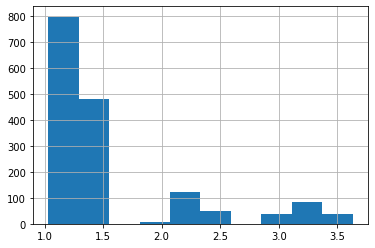

In [45]:
sales.price.hist()

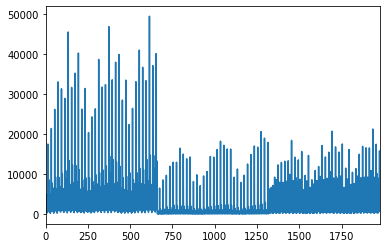

In [46]:
customers.amount_of_customers.plot()

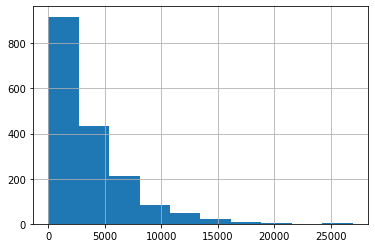

In [47]:
sales.volume.hist()

In [48]:
customers.corr()

,year,month,amount_of_customers
year,1.000000,-0.170318,0.029926
month,-0.170318,1.000000,0.028244
amount_of_customers,0.029926,0.028244,1.000000


In [49]:
sales.corr()

,year,month,item_per_bundle,volume,price
year,1.000000,-0.303836,-0.057474,-0.070941,0.071494
month,-0.303836,1.000000,-0.002873,0.075660,0.010288
item_per_bundle,-0.057474,-0.002873,1.000000,0.361457,0.984051
volume,-0.070941,0.075660,0.361457,1.000000,0.362815
price,0.071494,0.010288,0.984051,0.362815,1.000000


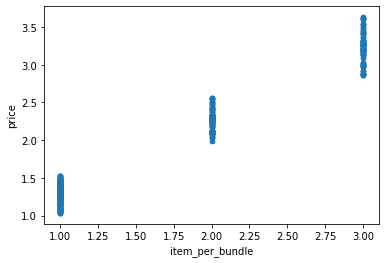

In [50]:
sales.plot.scatter(x='item_per_bundle', y='price')

In [51]:
sales.groupby('item_per_bundle').count()

,year,month,location,ira,product_category,brand,sku_id,shape,with_alcohol,filling,volume,price
item_per_bundle,,,,,,,,,,,,
1,1346,1346,1346,1346,1346,1346,1346,1346,1346,1346,1346,1282
2,203,203,203,203,203,203,203,203,203,203,203,179
3,180,180,180,180,180,180,180,180,180,180,180,156


In [52]:
correlation = sales.corr(method='pearson')
columns = correlation.nlargest(10, 'volume').index
columns

Index(['volume', 'price', 'item_per_bundle', 'month', 'year'], dtype='object')

## We can see the big correlation between 'price' and 'item_per_bundle' and it is cleat that price depending on quantity of products. In our task we have only 3 values of 'item_per_bundle' and correspondingly 3 small ranges of prices which are clearly visible on scatter plot. And maybe this is partly explains why dataframe without 'price' column works almost the same or even better despite the fact that it have one of the biggest correlation with volume

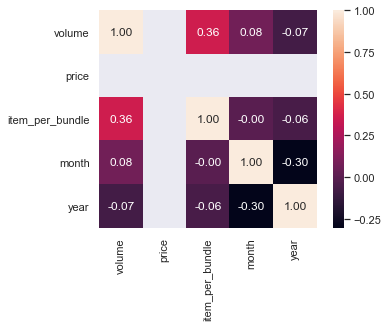

In [53]:
correlation_map = np.corrcoef(sales[columns].values.T)
sns.set(font_scale=1.0)
heatmap = sns.heatmap(correlation_map, cbar=True, annot=True, square=True, fmt='.2f', yticklabels=columns.values, xticklabels=columns.values)

plt.show()

In [54]:
sales.head()

,year,month,location,ira,product_category,brand,sku_id,item_per_bundle,shape,with_alcohol,filling,volume,price
0,2017,1,Alpha City,AC,Chocolates,Cadbury,sku #79,1,Standart,No,Nothing,4572.0,NaN
1,2017,1,Alpha City,AC,Chocolates,Ferrero Rocher,sku #15,1,Standart,No,Nothing,8028.0,1.221336
2,2017,1,Alpha City,AC,Chocolates,Ferrero Rocher,sku #16,3,Standart,No,Nothing,6606.0,2.866401
3,2017,1,Alpha City,AC,Chocolates,Ferrero Rocher,sku #22,2,Standart,No,Nothing,11688.0,2.093719
4,2017,1,Alpha City,AC,Chocolates,Ferrero Rocher,sku #28,3,Standart,No,Nothing,3582.0,2.866401


## Let's add one new feature 'price_per_item'

In [55]:
OH_sales_without_nan_rows['price_per_item'] = OH_sales_without_nan_rows.price / OH_sales_without_nan_rows.item_per_bundle

In [56]:
OH_sales_without_nan_rows.head(10)

,year,month,item_per_bundle,volume,price,location_Alpha City,location_Moon,location_Pirate Bay,location_Village,ira_AC,...,sku_id_sku #98,shape_Round,shape_Square,shape_Standart,with_alcohol_No,with_alcohol_Yes,filling_Berries,filling_Nothing,filling_Nuts,price_per_item
1,2017,1,1,8028.0,1.221336,1,0,0,0,1,...,0,0,0,1,1,0,0,1,0,1.221336
2,2017,1,3,6606.0,2.866401,1,0,0,0,1,...,0,0,0,1,1,0,0,1,0,0.955467
3,2017,1,2,11688.0,2.093719,1,0,0,0,1,...,0,0,0,1,1,0,0,1,0,1.046859
4,2017,1,3,3582.0,2.866401,1,0,0,0,1,...,0,0,0,1,1,0,0,1,0,0.955467
5,2017,1,1,5964.0,1.221336,1,0,0,0,1,...,0,0,0,1,1,0,0,1,0,1.221336
6,2017,1,1,1734.0,1.221336,1,0,0,0,1,...,0,0,1,0,1,0,0,1,0,1.221336
7,2017,1,1,432.0,1.221336,1,0,0,0,1,...,0,0,0,1,1,0,0,1,0,1.221336
8,2017,1,1,942.0,1.221336,1,0,0,0,1,...,0,0,0,1,0,1,0,1,0,1.221336
9,2017,1,1,1536.0,1.221336,1,0,0,0,1,...,0,0,0,1,1,0,0,1,0,1.221336
10,2017,1,1,1926.0,1.221336,1,0,0,0,1,...,0,0,0,1,1,0,0,1,0,1.221336


In [57]:
X = np.array(OH_sales_without_nan_rows.drop("volume", axis=1))
y = np.array(OH_sales_without_nan_rows["volume"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model_scores()

LinearRegression 57.91518125511713


C:\Users\Dmitriy\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 92024098.08462715, tolerance: 1528490.4653319414
  positive)
C:\Users\Dmitriy\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46231817.0137167, tolerance: 1297865.543465474
  positive)
C:\Users\Dmitriy\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58335328.36480856, tolerance: 1198156.7217868469
  positive)
C:\Users\Dmitriy\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dual

Lasso 57.91543289090335
Ridge 57.46204497978435
SVR 82.97029991306664
NuSVR 82.15760703653179
DecisionTree 33.010941996145206
ElasticNet 72.4983274549344
SGDRegressor 199.9999999994215
GradientBoostingRegressor 40.762216547665304
KNeighborsRegressor 46.297857987806246
GaussianProcessRegressor 34.35398915056071
RandomForestRegressor 26.297809221367864
ExtraTreesRegressor 25.867297508403038
BaggingRegressor 27.891924172255198
LGBMRegressor 43.792973089554664
XGBRegressor 41.52103280120927


## It didn't help (

## Now I want to drop 'item_per_bundle'

In [58]:
OH_sales_without_nan_rows_and_item_per_bundle = OH_sales_without_nan_rows.drop('item_per_bundle', axis=1)

In [59]:
X = np.array(OH_sales_without_nan_rows_and_item_per_bundle.drop("volume", axis=1))
y = np.array(OH_sales_without_nan_rows_and_item_per_bundle["volume"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model_scores()

LinearRegression 57.900226812394294


C:\Users\Dmitriy\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3043460.656149864, tolerance: 1198156.7217868469
  positive)


Lasso 58.028919941663176
Ridge 57.59081025548924
SVR 83.00006116567808
NuSVR 82.17674225559763
DecisionTree 32.68885211986132
ElasticNet 73.34738004187759
SGDRegressor 199.99999999865184
GradientBoostingRegressor 40.72086017255932
KNeighborsRegressor 46.023083874310345
GaussianProcessRegressor 34.315197383794974
RandomForestRegressor 26.42280864854045
ExtraTreesRegressor 25.59254621167211
BaggingRegressor 27.103881301399344
LGBMRegressor 43.78680082049691
XGBRegressor 41.52103280120927


## And it's also didn't really help. So we can return everything as it was

In [60]:
OH_sales_without_nan_rows = OH_sales_without_nan_rows.drop('price_per_item', axis=1)

## Now let's go ahead and look at the importance of features

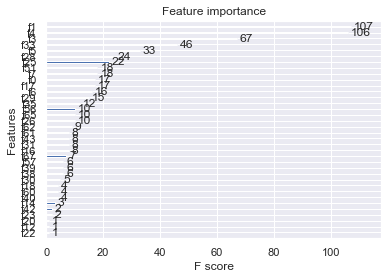

In [61]:
reg = xgb.XGBRegressor(objective="reg:squarederror")
X = np.array(OH_sales_without_nan_rows.drop("volume", axis=1))
y = np.array(OH_sales_without_nan_rows["volume"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
reg.fit(X_train, y_train)
xgb.plot_importance(reg)

In [62]:
reg = ExtraTreesRegressor(n_estimators=100)
X = np.array(OH_sales_without_nan_rows.drop("volume", axis=1))
y = np.array(OH_sales_without_nan_rows["volume"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
reg.fit(X_train, y_train)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
                    max_features='auto', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
                    oob_score=False, random_state=None, verbose=0,
                    warm_start=False)

In [63]:
feature_importances = reg.feature_importances_

In [64]:
pd.DataFrame({'features': list(pd.get_dummies(sales).drop(["volume"], axis=1)), 
              'feature_importances': feature_importances}).sort_values(by='feature_importances', ascending=False)

,features,feature_importances
28,sku_id_sku #22,0.224989
33,sku_id_sku #30,0.103402
3,price,0.082597
25,sku_id_sku #15,0.081314
1,month,0.079441
8,ira_AC,0.055617
4,location_Alpha City,0.052430
2,item_per_bundle,0.049932
29,sku_id_sku #25,0.024859
0,year,0.023405


## Here we can notice that most important features are: 'sku_id', 'price', 'month', 'ira', 'year'; and that Alpha City is more important what was said in presentation to this task.

# Let's try to add data about customers in our table

In [65]:
table = pd.pivot_table(customers, values='amount_of_customers', index=['year', 'month', 'ira'], columns=['customers_type'], aggfunc=np.sum)

In [66]:
table = table.reset_index()

In [67]:
table.head()

customers_type,year,month,ira,Angel,Archer,Centaur,Demon,Dwarf,Elf,Gargoyle,...,Goblin,Gremlin,Medusa,Minotaur,Monk,Orc,Pegasus,Pirate,Unicorn,other
0,2017,1,AC,1527.0,679.0,1315.0,575.0,610.0,5882.0,1268.0,...,399.0,1554.0,441.0,235.0,1070.0,2523.0,1027.0,17465.0,2501.0,8549.0
1,2017,1,MN,455.0,39.0,62.0,39.0,22.0,279.0,205.0,...,109.0,299.0,217.0,54.0,45.0,57.0,251.0,6461.0,1176.0,1186.0
2,2017,1,PB,4363.0,121.0,389.0,139.0,251.0,1921.0,541.0,...,542.0,6242.0,529.0,1227.0,488.0,2934.0,751.0,6620.0,2224.0,6355.0
3,2017,2,AC,1675.0,717.0,1601.0,524.0,457.0,4002.0,1176.0,...,415.0,1713.0,434.0,141.0,864.0,1740.0,895.0,21367.0,2250.0,7696.0
4,2017,2,MN,550.0,48.0,93.0,38.0,15.0,316.0,240.0,...,144.0,398.0,255.0,41.0,48.0,57.0,295.0,8504.0,801.0,1272.0


In [68]:
sales_with_customers = sales_without_nan_rows.merge(table, how='outer')

In [69]:
sales_with_customers = sales_with_customers[:-9]

In [70]:
sales_with_customers.shape

(1617, 33)

In [71]:
sales_with_customers.isna().sum()

year                 0
month                0
location             0
ira                  0
product_category     0
brand                0
sku_id               0
item_per_bundle      0
shape                0
with_alcohol         0
filling              0
volume               0
price                0
Angel               35
Archer              35
Centaur             35
Demon               35
Dwarf               35
Elf                 35
Gargoyle            35
Genie               35
Ghost               35
Giant               35
Goblin              35
Gremlin             35
Medusa              35
Minotaur            35
Monk                35
Orc                 35
Pegasus             35
Pirate              35
Unicorn             35
other               35
dtype: int64

# Now we need to add 'Village' customers. We can use imputation or just drop a few rows.

In [72]:
customers_types = customers.customers_type.unique()

In [73]:
d = {}
for key in customers_types:
    d[key] = table[key].mean()

In [74]:
d

{'Archer': 370.7878787878788,
 'Monk': 509.06060606060606,
 'Dwarf': 392.27272727272725,
 'Centaur': 1068.7575757575758,
 'Gremlin': 3657.1717171717173,
 'Genie': 3014.040404040404,
 'Demon': 576.9494949494949,
 'Ghost': 710.4949494949495,
 'Minotaur': 456.7979797979798,
 'Medusa': 466.82828282828285,
 'Goblin': 456.85858585858585,
 'Orc': 1160.3535353535353,
 'Gargoyle': 919.8181818181819,
 'Pegasus': 750.979797979798,
 'Pirate': 20072.858585858587,
 'Unicorn': 1973.828282828283,
 'Giant': 659.7878787878788,
 'Elf': 3411.717171717172,
 'Angel': 1492.0,
 'other': 6590.393939393939}

In [75]:
sales_with_customers_imputation = sales_with_customers.fillna(d)[:-9]

In [76]:
sales_with_customers.columns[13:33]

Index(['Angel', 'Archer', 'Centaur', 'Demon', 'Dwarf', 'Elf', 'Gargoyle',
       'Genie', 'Ghost', 'Giant', 'Goblin', 'Gremlin', 'Medusa', 'Minotaur',
       'Monk', 'Orc', 'Pegasus', 'Pirate', 'Unicorn', 'other'],
      dtype='object')

In [77]:
sales_with_customers_imputation = pd.get_dummies(sales_with_customers_imputation)

In [78]:
X = np.array(sales_with_customers_imputation.drop('volume', axis=1))
y = np.array(sales_with_customers_imputation['volume'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model_scores()

LinearRegression 59.755374490912615


C:\Users\Dmitriy\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1824015452.0610566, tolerance: 1526979.337961431
  positive)
C:\Users\Dmitriy\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1483892858.8924172, tolerance: 1234112.4485264593
  positive)
C:\Users\Dmitriy\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1494191240.9069636, tolerance: 1224723.3581407191
  positive)
C:\Users\Dmitriy\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

Lasso 59.35712539742068
Ridge 58.68986250538823
SVR 83.04418673931787
NuSVR 82.0315829938443
DecisionTree 37.670256162027655


C:\Users\Dmitriy\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5413265335.04554, tolerance: 1526979.337961431
  positive)
C:\Users\Dmitriy\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4338070995.985648, tolerance: 1234112.4485264593
  positive)
C:\Users\Dmitriy\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4301251099.008631, tolerance: 1224723.3581407191
  positive)
C:\Users\Dmitriy\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dual

ElasticNet 68.96402730271551
SGDRegressor 199.99999999998366
GradientBoostingRegressor 41.005678380799345
KNeighborsRegressor 76.54828801862803
GaussianProcessRegressor 78.87198395360141
RandomForestRegressor 29.27468680681401
ExtraTreesRegressor 25.084297836174027
BaggingRegressor 31.137211488347553
LGBMRegressor 43.785530952619595
XGBRegressor 42.127817934624076


In [79]:
sales_with_customers_drop = sales_with_customers[sales_with_customers.ira != "VL"]

In [80]:
sales_with_customers_drop.shape

(1582, 33)

In [81]:
sales_with_customers_drop = pd.get_dummies(sales_with_customers_drop)

In [82]:
X = np.array(sales_with_customers_drop.drop('volume', axis=1))
y = np.array(sales_with_customers_drop['volume'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model_scores()

LinearRegression 55.37306821248551


C:\Users\Dmitriy\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1585454557.347032, tolerance: 1445113.8252613437
  positive)
C:\Users\Dmitriy\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1252251830.092407, tolerance: 1130783.7872651187
  positive)
C:\Users\Dmitriy\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1283964660.3710268, tolerance: 1204688.592393676
  positive)
C:\Users\Dmitriy\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Du

Lasso 54.53351936093931
Ridge 54.032342366626175
SVR 80.65336906642293
NuSVR 79.93315552636045
DecisionTree 37.24352756248382


C:\Users\Dmitriy\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5167671342.270373, tolerance: 1445113.8252613437
  positive)
C:\Users\Dmitriy\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4016192898.2689967, tolerance: 1130783.7872651187
  positive)
C:\Users\Dmitriy\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4212592962.9707093, tolerance: 1204688.592393676
  positive)
C:\Users\Dmitriy\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. D

ElasticNet 68.01989302206346
SGDRegressor 199.9999999999938
GradientBoostingRegressor 38.884198080309545
KNeighborsRegressor 77.24557359077963
GaussianProcessRegressor 80.22549225138965
RandomForestRegressor 29.183929510741024
ExtraTreesRegressor 25.43107285461578
BaggingRegressor 30.56155607876674
LGBMRegressor 42.10871548587848
XGBRegressor 39.32986529558683


## Here it's better to use imputation

## Now let's try to add new feature 'total_customers'. And then remove the quantity of each type of customer.

In [83]:
sales_with_customers_imputation['total_customers'] = sales_with_customers_imputation.iloc[:, 5:25].sum(axis=1)

In [84]:
X = np.array(sales_with_customers_imputation.drop('volume', axis=1))
y = np.array(sales_with_customers_imputation['volume'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model_scores()

LinearRegression 59.779776890655


C:\Users\Dmitriy\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1819187404.274648, tolerance: 1526979.337961431
  positive)
C:\Users\Dmitriy\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1475981353.7263005, tolerance: 1234112.4485264593
  positive)
C:\Users\Dmitriy\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1489911899.4822195, tolerance: 1224723.3581407191
  positive)
C:\Users\Dmitriy\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. D

Lasso 59.3404625128432
Ridge 58.68986249423752
SVR 83.04416481997916
NuSVR 82.03157449738487
DecisionTree 37.9572925011576


C:\Users\Dmitriy\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5407413440.084967, tolerance: 1526979.337961431
  positive)
C:\Users\Dmitriy\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4335247005.084467, tolerance: 1234112.4485264593
  positive)
C:\Users\Dmitriy\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4299018836.222867, tolerance: 1224723.3581407191
  positive)
C:\Users\Dmitriy\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dua

ElasticNet 68.9689809277338
SGDRegressor 200.0
GradientBoostingRegressor 41.34307028090067
KNeighborsRegressor 76.2160683154415
GaussianProcessRegressor 78.87198395360141
RandomForestRegressor 29.439383856087478
ExtraTreesRegressor 24.86380317706989
BaggingRegressor 31.193862930205928
LGBMRegressor 43.6320512242024
XGBRegressor 41.754633486719314


## Yeah. It's become slightly better (24.86380317706989 %)

In [85]:
sales_with_total_customers = sales_with_customers_imputation.drop(sales_with_customers_imputation.columns[5:25], axis=1)

In [86]:
X = np.array(sales_with_total_customers.drop('volume', axis=1))
y = np.array(sales_with_total_customers['volume'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model_scores()

LinearRegression 58.381456256571724


C:\Users\Dmitriy\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2814112.348804474, tolerance: 1224723.3581407191
  positive)


Lasso 57.489273816989375
Ridge 56.9565966730986
SVR 83.04459274385479
NuSVR 82.0316885335229
DecisionTree 33.06724594262981
ElasticNet 67.94539271440479
SGDRegressor 199.99999999966445
GradientBoostingRegressor 41.435092496982165
KNeighborsRegressor 76.09074919358945
GaussianProcessRegressor 78.87198395360141
RandomForestRegressor 26.97900871656838
ExtraTreesRegressor 24.444748189358343
BaggingRegressor 28.37451717506134
LGBMRegressor 42.662185152255866
XGBRegressor 41.96113249495087


## Even more better (24.392011498286106 %)

# Predicting volume for next 3 months

## We will be making predictions for 'location' and for 'sku_id' which was presented in our data, because not in every 'location' we had data about some 'sku_id'.

In [87]:
data_for_forecast = {'year': [], 'month': [], 'location': [], 'sku_id': [], 'price': [], 'ira': []}

In [88]:
data_for_forecast

{'year': [], 'month': [], 'location': [], 'sku_id': [], 'price': [], 'ira': []}

In [89]:
for year in [2019]:
    for month in [7, 8, 9]:
        for sku in sales.sku_id.unique():
            for location in sales[sales.sku_id == sku].location.unique():
                data_for_forecast['year'].append(year)
                data_for_forecast['month'].append(month)
                data_for_forecast['sku_id'].append(sku)
                data_for_forecast['location'].append(location)
                data_for_forecast['ira'].append(sales[sales.location == location].ira.iloc[0])
                data_for_forecast['price'].append(sales[sales.sku_id == sku].price.iloc[-1])

In [90]:
additional_columns = sales[['sku_id', 'product_category', 'brand', 'item_per_bundle', 'shape', 'with_alcohol', 'filling']].drop_duplicates()

In [91]:
additional_columns

,sku_id,product_category,brand,item_per_bundle,shape,with_alcohol,filling
0,sku #79,Chocolates,Cadbury,1,Standart,No,Nothing
1,sku #15,Chocolates,Ferrero Rocher,1,Standart,No,Nothing
2,sku #16,Chocolates,Ferrero Rocher,3,Standart,No,Nothing
3,sku #22,Chocolates,Ferrero Rocher,2,Standart,No,Nothing
4,sku #28,Chocolates,Ferrero Rocher,3,Standart,No,Nothing
5,sku #30,Chocolates,Ferrero Rocher,1,Standart,No,Nothing
6,sku #31,Chocolates,Ferrero Rocher,1,Square,No,Nothing
7,sku #33,Chocolates,Ferrero Rocher,1,Standart,No,Nothing
8,sku #38,Chocolates,Ferrero Rocher,1,Standart,Yes,Nothing
9,sku #41,Chocolates,Ferrero Rocher,1,Standart,No,Nothing


In [92]:
additional_columns.shape

(43, 7)

In [93]:
sales.sku_id.unique().size

43

## Also we can notice that together with "sku_id", other entities are uniquely defined, such as 'product_category', 'brand', 'item_per_bundle', 'shape', 'with_alcohol', 'filling'. So the difference between rows only in the location, price, volume and date.

In [94]:
data_for_forecast = pd.DataFrame(data_for_forecast)

In [95]:
data_for_forecast = data_for_forecast.merge(additional_columns)

## Removing categorical feature with One-Hot Encoding

In [96]:
table = table[-9:]

In [97]:
table

customers_type,year,month,ira,Angel,Archer,Centaur,Demon,Dwarf,Elf,Gargoyle,...,Goblin,Gremlin,Medusa,Minotaur,Monk,Orc,Pegasus,Pirate,Unicorn,other
90,2019,7,AC,1621.0,986.0,3203.0,1967.0,1130.0,11782.0,1890.0,...,835.0,2641.0,758.0,427.0,1874.0,2103.0,1396.0,49427.0,3385.0,14668.0
91,2019,7,MN,719.0,118.0,251.0,85.0,54.0,1044.0,418.0,...,278.0,532.0,232.0,67.0,106.0,131.0,377.0,20592.0,1310.0,2467.0
92,2019,7,PB,1584.0,202.0,987.0,317.0,365.0,3043.0,908.0,...,553.0,10825.0,386.0,1011.0,348.0,1026.0,705.0,21231.0,2191.0,8870.0
93,2019,8,AC,2063.0,977.0,3504.0,1701.0,1275.0,11544.0,1726.0,...,725.0,2911.0,791.0,371.0,1619.0,2270.0,1935.0,37069.0,2959.0,14629.0
94,2019,8,MN,806.0,112.0,285.0,78.0,114.0,1109.0,622.0,...,343.0,539.0,253.0,92.0,103.0,130.0,485.0,18947.0,1622.0,2888.0
95,2019,8,PB,1745.0,173.0,1097.0,269.0,377.0,2726.0,932.0,...,515.0,9162.0,398.0,1174.0,315.0,1103.0,804.0,17410.0,1897.0,10084.0
96,2019,9,AC,1629.0,941.0,3109.0,1647.0,1072.0,10205.0,1972.0,...,741.0,2240.0,687.0,461.0,1811.0,2380.0,1397.0,40099.0,2987.0,13207.0
97,2019,9,MN,672.0,116.0,222.0,78.0,83.0,1048.0,519.0,...,382.0,485.0,335.0,58.0,95.0,117.0,471.0,17885.0,1204.0,2566.0
98,2019,9,PB,1355.0,233.0,830.0,250.0,332.0,2477.0,824.0,...,534.0,8976.0,540.0,1066.0,334.0,948.0,798.0,15752.0,1896.0,8062.0


In [98]:
data_for_forecast = data_for_forecast.merge(table, how='outer')

In [99]:
data_for_forecast = data_for_forecast.fillna(d)

In [100]:
data_for_forecast

,year,month,location,sku_id,price,ira,product_category,brand,item_per_bundle,shape,...,Goblin,Gremlin,Medusa,Minotaur,Monk,Orc,Pegasus,Pirate,Unicorn,other
0,2019,7,Alpha City,sku #79,1.276329,AC,Chocolates,Cadbury,1,Standart,...,835.000000,2641.000000,758.000000,427.00000,1874.000000,2103.000000,1396.000000,49427.000000,3385.000000,14668.000000
1,2019,7,Alpha City,sku #15,1.339017,AC,Chocolates,Ferrero Rocher,1,Standart,...,835.000000,2641.000000,758.000000,427.00000,1874.000000,2103.000000,1396.000000,49427.000000,3385.000000,14668.000000
2,2019,7,Alpha City,sku #16,3.415246,AC,Chocolates,Ferrero Rocher,3,Standart,...,835.000000,2641.000000,758.000000,427.00000,1874.000000,2103.000000,1396.000000,49427.000000,3385.000000,14668.000000
3,2019,7,Alpha City,sku #22,2.412237,AC,Chocolates,Ferrero Rocher,2,Standart,...,835.000000,2641.000000,758.000000,427.00000,1874.000000,2103.000000,1396.000000,49427.000000,3385.000000,14668.000000
4,2019,7,Alpha City,sku #28,3.415246,AC,Chocolates,Ferrero Rocher,3,Standart,...,835.000000,2641.000000,758.000000,427.00000,1874.000000,2103.000000,1396.000000,49427.000000,3385.000000,14668.000000
5,2019,7,Alpha City,sku #30,1.251254,AC,Chocolates,Ferrero Rocher,1,Standart,...,835.000000,2641.000000,758.000000,427.00000,1874.000000,2103.000000,1396.000000,49427.000000,3385.000000,14668.000000
6,2019,7,Alpha City,sku #31,1.339017,AC,Chocolates,Ferrero Rocher,1,Square,...,835.000000,2641.000000,758.000000,427.00000,1874.000000,2103.000000,1396.000000,49427.000000,3385.000000,14668.000000
7,2019,7,Alpha City,sku #33,1.278700,AC,Chocolates,Ferrero Rocher,1,Standart,...,835.000000,2641.000000,758.000000,427.00000,1874.000000,2103.000000,1396.000000,49427.000000,3385.000000,14668.000000
8,2019,7,Alpha City,sku #38,1.339017,AC,Chocolates,Ferrero Rocher,1,Standart,...,835.000000,2641.000000,758.000000,427.00000,1874.000000,2103.000000,1396.000000,49427.000000,3385.000000,14668.000000
9,2019,7,Alpha City,sku #41,1.339017,AC,Chocolates,Ferrero Rocher,1,Standart,...,835.000000,2641.000000,758.000000,427.00000,1874.000000,2103.000000,1396.000000,49427.000000,3385.000000,14668.000000


In [101]:
data_for_forecast['total_customers'] = data_for_forecast.iloc[:, -20:].sum(axis=1)

In [102]:
data_for_forecast = data_for_forecast.drop(data_for_forecast.columns[-21:-1], axis=1)

In [103]:
OH_data_for_forecast = pd.get_dummies(data_for_forecast)

In [104]:
OH_data_for_forecast

,year,month,price,item_per_bundle,total_customers,location_Alpha City,location_Moon,location_Pirate Bay,location_Village,sku_id_sku #100,...,brand_Toblerone,brand_Twix,shape_Round,shape_Square,shape_Standart,with_alcohol_No,with_alcohol_Yes,filling_Berries,filling_Nothing,filling_Nuts
0,2019,7,1.276329,1,111952.000000,1,0,0,0,0,...,0,0,0,0,1,1,0,0,1,0
1,2019,7,1.339017,1,111952.000000,1,0,0,0,0,...,0,0,0,0,1,1,0,0,1,0
2,2019,7,3.415246,3,111952.000000,1,0,0,0,0,...,0,0,0,0,1,1,0,0,1,0
3,2019,7,2.412237,2,111952.000000,1,0,0,0,0,...,0,0,0,0,1,1,0,0,1,0
4,2019,7,3.415246,3,111952.000000,1,0,0,0,0,...,0,0,0,0,1,1,0,0,1,0
5,2019,7,1.251254,1,111952.000000,1,0,0,0,0,...,0,0,0,0,1,1,0,0,1,0
6,2019,7,1.339017,1,111952.000000,1,0,0,0,0,...,0,0,0,1,0,1,0,0,1,0
7,2019,7,1.278700,1,111952.000000,1,0,0,0,0,...,0,0,0,0,1,1,0,0,1,0
8,2019,7,1.339017,1,111952.000000,1,0,0,0,0,...,0,0,0,0,1,0,1,0,1,0
9,2019,7,1.339017,1,111952.000000,1,0,0,0,0,...,0,0,0,0,1,1,0,0,1,0


In [105]:
sales_with_total_customers.shape

(1608, 74)

In [106]:
X = np.array(sales_with_total_customers.drop('volume', axis=1))
y = np.array(sales_with_total_customers['volume'])
best_model = ExtraTreesRegressor(n_estimators=100)
best_model.fit(X, y)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
                    max_features='auto', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
                    oob_score=False, random_state=None, verbose=0,
                    warm_start=False)

In [107]:
predicted_volumes = best_model.predict(OH_data_for_forecast)

In [108]:
predicted_volumes

array([3126.3 , 3032.34, 3068.82, 4712.2 , 1743.  , 2960.76, 2949.72,
       3032.64, 3076.18, 3042.78, 2968.08, 2759.98, 6289.22, 6621.39,
       2829.24, 2441.88, 2887.38, 3170.94, 3002.52, 3032.34, 2296.57,
       2161.71, 2159.61, 2228.5 , 3105.27, 2928.45, 3166.08, 4651.2 ,
       1734.66, 2801.82, 2812.14, 2916.42, 2956.  , 2923.62, 2829.48,
       2713.5 , 5608.04, 8048.51, 2814.75, 2417.94, 2776.98, 2796.78,
       3111.06, 2904.81, 2001.37, 1909.59, 1909.59, 1998.76, 2824.68,
       2433.78, 3062.88, 3054.48, 4726.62, 1620.84, 2744.94, 2827.98,
       2874.84, 2767.86, 2704.86, 2340.78, 2728.86, 2743.08, 6503.94,
       2725.62, 3814.62, 2920.44, 2837.7 , 2772.24, 3054.48, 2808.54,
       3054.48, 3112.2 , 2741.4 , 2885.34, 2787.78, 2736.18, 2184.52,
       2114.88, 2116.02, 2149.15, 2646.48, 4723.2 , 2775.3 , 3140.22,
       3013.32, 3091.5 , 4724.98, 1794.  , 2935.86, 2930.7 , 3007.74,
       3057.16, 3021.  , 2938.86, 2797.96, 6208.7 , 6537.39, 2810.22,
       2416.5 , 2862

In [109]:
output = data_for_forecast.drop(['product_category', 'brand', 'item_per_bundle', 'shape', 'with_alcohol', 'filling', 'price', 'total_customers'], axis=1)

In [110]:
output['volume'] = predicted_volumes

In [111]:
output.isna().sum()

year        0
month       0
location    0
sku_id      0
ira         0
volume      0
dtype: int64

In [112]:
output

,year,month,location,sku_id,ira,volume
0,2019,7,Alpha City,sku #79,AC,3126.30
1,2019,7,Alpha City,sku #15,AC,3032.34
2,2019,7,Alpha City,sku #16,AC,3068.82
3,2019,7,Alpha City,sku #22,AC,4712.20
4,2019,7,Alpha City,sku #28,AC,1743.00
5,2019,7,Alpha City,sku #30,AC,2960.76
6,2019,7,Alpha City,sku #31,AC,2949.72
7,2019,7,Alpha City,sku #33,AC,3032.64
8,2019,7,Alpha City,sku #38,AC,3076.18
9,2019,7,Alpha City,sku #41,AC,3042.78


## Finally we had the predictions for our 3 months. Let's save it

In [113]:
output.to_csv('submission.tsv', index=False, sep='\t')

In [114]:
df = pd.read_csv('submission.tsv', sep='\t')

In [115]:
df

,year,month,location,sku_id,ira,volume
0,2019,7,Alpha City,sku #79,AC,3126.30
1,2019,7,Alpha City,sku #15,AC,3032.34
2,2019,7,Alpha City,sku #16,AC,3068.82
3,2019,7,Alpha City,sku #22,AC,4712.20
4,2019,7,Alpha City,sku #28,AC,1743.00
5,2019,7,Alpha City,sku #30,AC,2960.76
6,2019,7,Alpha City,sku #31,AC,2949.72
7,2019,7,Alpha City,sku #33,AC,3032.64
8,2019,7,Alpha City,sku #38,AC,3076.18
9,2019,7,Alpha City,sku #41,AC,3042.78


# And now we would try to find a better price for each SKU. 

## For this we will be changing in loop the price from -15% to +15% and predicting the volume with our 'best_model' and count the total revenues.

In [116]:
OH_data_for_forecast['volume'] = predicted_volumes

In [117]:
OH_data_for_forecast.head()

,year,month,price,item_per_bundle,total_customers,location_Alpha City,location_Moon,location_Pirate Bay,location_Village,sku_id_sku #100,...,brand_Twix,shape_Round,shape_Square,shape_Standart,with_alcohol_No,with_alcohol_Yes,filling_Berries,filling_Nothing,filling_Nuts,volume
0,2019,7,1.276329,1,111952.0,1,0,0,0,0,...,0,0,0,1,1,0,0,1,0,3126.30
1,2019,7,1.339017,1,111952.0,1,0,0,0,0,...,0,0,0,1,1,0,0,1,0,3032.34
2,2019,7,3.415246,3,111952.0,1,0,0,0,0,...,0,0,0,1,1,0,0,1,0,3068.82
3,2019,7,2.412237,2,111952.0,1,0,0,0,0,...,0,0,0,1,1,0,0,1,0,4712.20
4,2019,7,3.415246,3,111952.0,1,0,0,0,0,...,0,0,0,1,1,0,0,1,0,1743.00


## Counting current revenue

In [118]:
current_revenue = OH_data_for_forecast[['price', 'volume']]

In [119]:
current_revenue = current_revenue.price * current_revenue.volume

In [120]:
current_revenue = current_revenue.sum()

In [121]:
current_revenue

1246546.2641579441

## Counting revenue with another prices

In [122]:
OH_data_for_forecast_with_another_price = OH_data_for_forecast.copy()
for percent in range(-15, 16):
    OH_data_for_forecast_with_another_price['price'] = OH_data_for_forecast['price'] + OH_data_for_forecast['price'] * percent / 100
    OH_data_for_forecast_with_another_price['volume'] = best_model.predict(OH_data_for_forecast_with_another_price.drop('volume', axis=1))
    revenue = OH_data_for_forecast_with_another_price[['price', 'volume']]
    revenue = revenue.price * revenue.volume
    revenue = revenue.sum()
    print(percent, revenue)

-15 1044103.2910469323
-14 1057330.8172011185
-13 1070606.6850344683
-12 1084962.7894417392
-11 1094656.0554270456
-10 1105498.7249693102
-9 1120223.4573886862
-8 1133537.3565550442
-7 1146512.9171270616
-6 1163113.5703755524
-5 1173955.5056519816
-4 1184580.0538651822
-3 1203034.712417591
-2 1218296.2851511287
-1 1232232.5695567445
0 1246546.2641579441
1 1260107.137842867
2 1275322.0421254728
3 1290277.5784863532
4 1304156.621496797
5 1317921.9680762044
6 1329739.5721063684
7 1341763.6882192523
8 1356969.337839843
9 1375464.680001975
10 1388257.2286802796
11 1401733.2976379024
12 1414320.0027427883
13 1422581.693178458
14 1427284.9582490064
15 1437967.2298959573


## We get that it's better to increase the price as much as possible. I think it's a bad prediction because revenue just linearly growth.

## This could happen for several reasons. We didn't get a good result because our model works almost the same without 'price' and not very depend from it. Most likely, this is a bad model or perhaps because we have a very small variation in price, as I noticed at the beginning. So a few percents will give us just a few cents to revenue, what probably not so valuable in our case.